In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import pandas as pd

/proj/berzelius-aiics-real/users/x_hodfa/generative/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.11.0
GPU Available: True


In [3]:
import numpy as np

In [5]:
import torchvision 
from torchvision import transforms 


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
fmnist_dataset = torchvision.datasets.FashionMNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader,Subset



# mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
#                       shuffle=True, drop_last=True)

26422272it [00:00, 78722405.75it/s]                                                                                                                                                     


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



29696it [00:00, 1496504.28it/s]                                                                                                                                                         

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



4422656it [00:00, 25948396.51it/s]                                                                                                                                                      


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



6144it [00:00, 34590340.64it/s]                                                                                                                                                         

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [6]:
idx = fmnist_dataset.targets == 9 
fmnist_dataset.targets = fmnist_dataset.targets[idx]
fmnist_dataset.data = fmnist_dataset.data[idx,:,:]

In [7]:
fmnist_dl = DataLoader(fmnist_dataset, batch_size=batch_size, 
                       shuffle=True, drop_last=True)

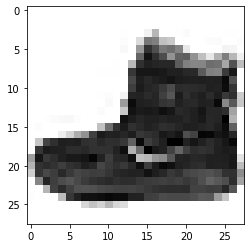

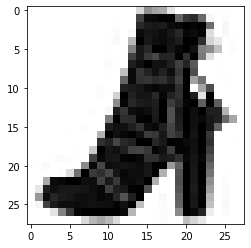

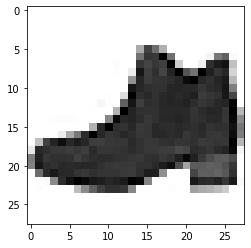

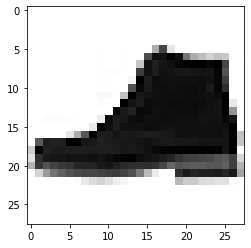

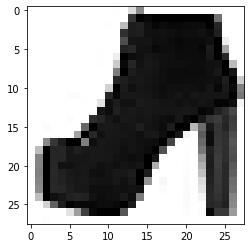

In [8]:
for i in range(5):
    image = fmnist_dl.dataset.data[i]
    plt.figure()
    plt.imshow(image,cmap='gray_r')
  #  plt.title(int(label))
plt.show()

# The DCGAN model

In [9]:
def generator(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [10]:
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = generator(z_size, n_filters).to(device)  
print(gen_model)
disc_model = Discriminator(n_filters).to(device)     
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [11]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [12]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [13]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [14]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()


In [15]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 400
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(fmnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
 
    print(f'Epoch {epoch:03d} '
          f' Generator loss: {torch.FloatTensor(g_losses).mean():.4f}'
          f' Discriminator loss:{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001  Generator loss: 3.0003 Discriminator loss:0.2348
Epoch 002  Generator loss: 4.0280 Discriminator loss:0.1388
Epoch 003  Generator loss: 3.7066 Discriminator loss:0.1869
Epoch 004  Generator loss: 3.0908 Discriminator loss:0.3290
Epoch 005  Generator loss: 3.1418 Discriminator loss:0.3155
Epoch 006  Generator loss: 3.2305 Discriminator loss:0.3083
Epoch 007  Generator loss: 3.1069 Discriminator loss:0.3265
Epoch 008  Generator loss: 2.9782 Discriminator loss:0.3888
Epoch 009  Generator loss: 3.1620 Discriminator loss:0.3118
Epoch 010  Generator loss: 3.3970 Discriminator loss:0.2721
Epoch 011  Generator loss: 3.2025 Discriminator loss:0.3522
Epoch 012  Generator loss: 3.2459 Discriminator loss:0.3644
Epoch 013  Generator loss: 3.0804 Discriminator loss:0.3646
Epoch 014  Generator loss: 3.3134 Discriminator loss:0.3627
Epoch 015  Generator loss: 2.9559 Discriminator loss:0.3753
Epoch 016  Generator loss: 2.7124 Discriminator loss:0.4386
Epoch 017  Generator loss: 2.7489 Discri

Epoch 138  Generator loss: 1.8072 Discriminator loss:0.7379
Epoch 139  Generator loss: 1.8655 Discriminator loss:0.7521
Epoch 140  Generator loss: 1.8903 Discriminator loss:0.7452
Epoch 141  Generator loss: 1.9319 Discriminator loss:0.7655
Epoch 142  Generator loss: 2.1002 Discriminator loss:0.6610
Epoch 143  Generator loss: 2.0172 Discriminator loss:0.7277
Epoch 144  Generator loss: 1.8435 Discriminator loss:0.7582
Epoch 145  Generator loss: 2.0778 Discriminator loss:0.6363
Epoch 146  Generator loss: 1.9214 Discriminator loss:0.7909
Epoch 147  Generator loss: 1.9969 Discriminator loss:0.6820
Epoch 148  Generator loss: 1.8334 Discriminator loss:0.7763
Epoch 149  Generator loss: 1.8821 Discriminator loss:0.7516
Epoch 150  Generator loss: 1.8906 Discriminator loss:0.6479
Epoch 151  Generator loss: 1.8476 Discriminator loss:0.7210
Epoch 152  Generator loss: 1.8459 Discriminator loss:0.7137
Epoch 153  Generator loss: 1.9213 Discriminator loss:0.7228
Epoch 154  Generator loss: 1.9867 Discri

Epoch 275  Generator loss: 2.5157 Discriminator loss:0.4260
Epoch 276  Generator loss: 2.6222 Discriminator loss:0.4232
Epoch 277  Generator loss: 2.5546 Discriminator loss:0.4616
Epoch 278  Generator loss: 2.5982 Discriminator loss:0.4171
Epoch 279  Generator loss: 2.6233 Discriminator loss:0.4442
Epoch 280  Generator loss: 2.6103 Discriminator loss:0.4289
Epoch 281  Generator loss: 2.5492 Discriminator loss:0.4200
Epoch 282  Generator loss: 2.6058 Discriminator loss:0.4170
Epoch 283  Generator loss: 2.5685 Discriminator loss:0.4318
Epoch 284  Generator loss: 2.6683 Discriminator loss:0.4338
Epoch 285  Generator loss: 2.6065 Discriminator loss:0.4505
Epoch 286  Generator loss: 2.6140 Discriminator loss:0.4091
Epoch 287  Generator loss: 2.6759 Discriminator loss:0.4062
Epoch 288  Generator loss: 2.6195 Discriminator loss:0.3964
Epoch 289  Generator loss: 2.6391 Discriminator loss:0.4304
Epoch 290  Generator loss: 2.6857 Discriminator loss:0.3958
Epoch 291  Generator loss: 2.6097 Discri

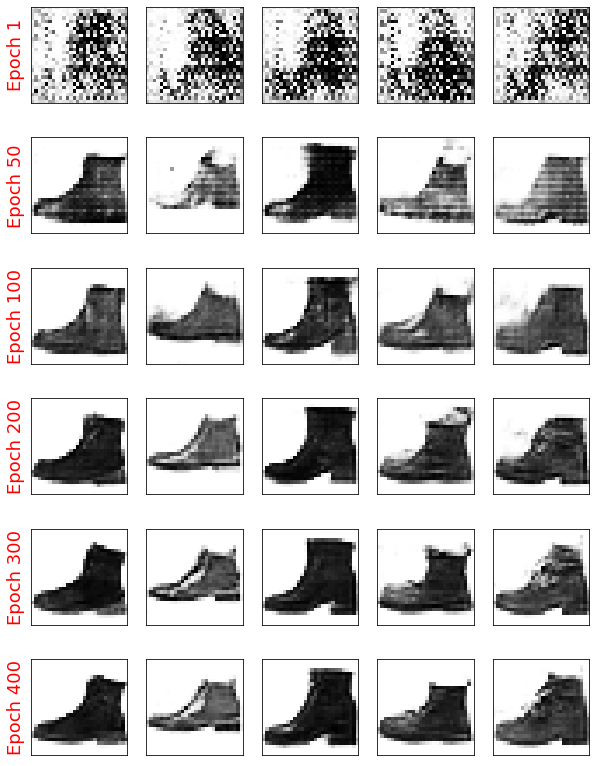

In [19]:
selected_epochs = [1,50,100,200, 300 , 400]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.savefig('dcgan-samples.pdf')
plt.show()

# Gradient Penalty

## Implementing WGAN-GP to train the DCGAN model

In [20]:
def generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [21]:
gen_model = generator_network_wgan(z_size, n_filters).to(device)  
disc_model = DiscriminatorWGAN(n_filters).to(device)  

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [22]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    
    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


In [23]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item()

In [24]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [25]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 400
torch.manual_seed(1)
critic_iterations = 5 

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(fmnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))
 

    
    print(f'Epoch {epoch:03d} '
          f' Generator loss: {torch.FloatTensor(g_losses).mean():.4f}'
          f' Discriminator loss:{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001  Generator loss: -0.2948 Discriminator loss:0.4737
Epoch 002  Generator loss: -0.2227 Discriminator loss:-0.0801
Epoch 003  Generator loss: -0.1899 Discriminator loss:-0.2783
Epoch 004  Generator loss: -0.1930 Discriminator loss:-0.3433
Epoch 005  Generator loss: -0.1872 Discriminator loss:-0.3796
Epoch 006  Generator loss: -0.2228 Discriminator loss:-0.3405
Epoch 007  Generator loss: -0.2214 Discriminator loss:-0.3623
Epoch 008  Generator loss: -0.2282 Discriminator loss:-0.3878
Epoch 009  Generator loss: -0.2303 Discriminator loss:-0.3998
Epoch 010  Generator loss: -0.2336 Discriminator loss:-0.4220
Epoch 011  Generator loss: -0.2437 Discriminator loss:-0.4340
Epoch 012  Generator loss: -0.2373 Discriminator loss:-0.4530
Epoch 013  Generator loss: -0.2393 Discriminator loss:-0.4411
Epoch 014  Generator loss: -0.2404 Discriminator loss:-0.4092
Epoch 015  Generator loss: -0.2402 Discriminator loss:-0.3781
Epoch 016  Generator loss: -0.2485 Discriminator loss:-0.3913
Epoch 017

Epoch 134  Generator loss: -0.2843 Discriminator loss:-0.4020
Epoch 135  Generator loss: -0.2875 Discriminator loss:-0.4125
Epoch 136  Generator loss: -0.2788 Discriminator loss:-0.4239
Epoch 137  Generator loss: -0.2729 Discriminator loss:-0.4291
Epoch 138  Generator loss: -0.2802 Discriminator loss:-0.4215
Epoch 139  Generator loss: -0.2775 Discriminator loss:-0.4154
Epoch 140  Generator loss: -0.2789 Discriminator loss:-0.4151
Epoch 141  Generator loss: -0.2816 Discriminator loss:-0.4160
Epoch 142  Generator loss: -0.2864 Discriminator loss:-0.4061
Epoch 143  Generator loss: -0.2783 Discriminator loss:-0.4188
Epoch 144  Generator loss: -0.2793 Discriminator loss:-0.4157
Epoch 145  Generator loss: -0.2880 Discriminator loss:-0.4081
Epoch 146  Generator loss: -0.2918 Discriminator loss:-0.4010
Epoch 147  Generator loss: -0.2842 Discriminator loss:-0.4095
Epoch 148  Generator loss: -0.2787 Discriminator loss:-0.4125
Epoch 149  Generator loss: -0.2892 Discriminator loss:-0.4098
Epoch 15

Epoch 267  Generator loss: -0.2992 Discriminator loss:-0.4136
Epoch 268  Generator loss: -0.2994 Discriminator loss:-0.4061
Epoch 269  Generator loss: -0.2910 Discriminator loss:-0.4135
Epoch 270  Generator loss: -0.2999 Discriminator loss:-0.4110
Epoch 271  Generator loss: -0.2986 Discriminator loss:-0.4082
Epoch 272  Generator loss: -0.2947 Discriminator loss:-0.4086
Epoch 273  Generator loss: -0.3002 Discriminator loss:-0.4111
Epoch 274  Generator loss: -0.2951 Discriminator loss:-0.4087
Epoch 275  Generator loss: -0.2911 Discriminator loss:-0.4116
Epoch 276  Generator loss: -0.2968 Discriminator loss:-0.4091
Epoch 277  Generator loss: -0.2969 Discriminator loss:-0.4077
Epoch 278  Generator loss: -0.2929 Discriminator loss:-0.4094
Epoch 279  Generator loss: -0.2914 Discriminator loss:-0.4278
Epoch 280  Generator loss: -0.3007 Discriminator loss:-0.4120
Epoch 281  Generator loss: -0.3006 Discriminator loss:-0.4053
Epoch 282  Generator loss: -0.3033 Discriminator loss:-0.3993
Epoch 28

Epoch 400  Generator loss: -0.2999 Discriminator loss:-0.4101


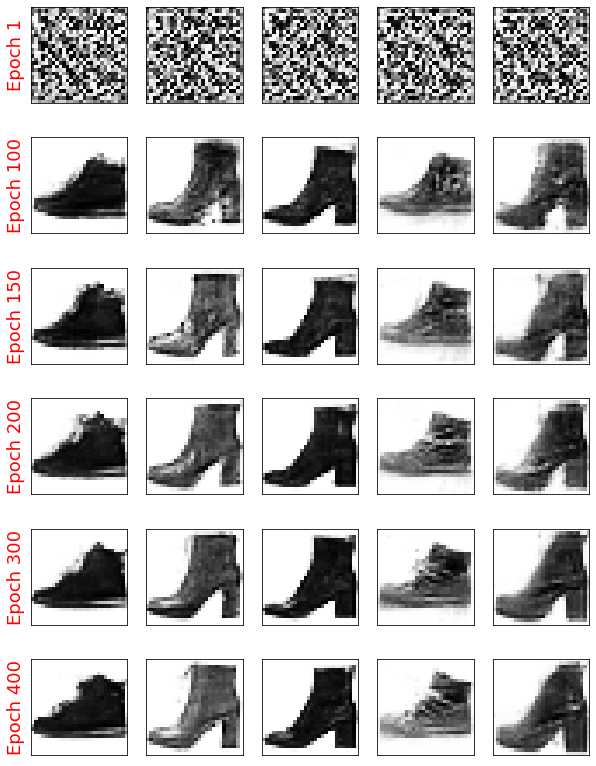

In [27]:
selected_epochs = [1,100,150 ,200, 300, 400]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.savefig('wgan-gp-samples.pdf')
plt.show()
